In [1]:
from rdkit import Chem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import KFold,LeaveOneOut
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
smi = pd.read_csv('./SMILES.csv')
er = smi['er'].to_numpy()
ee = np.array([i if not np.isnan(i) else 0 for i in er])/100*2-1   #er2ee
T = 80 + 273.15
ddG = -8.314 * T * np.log((1-ee)/(1+ee))/1000/4.18    # kcal/mol
scaler = StandardScaler()        
standard_input_y = pd.DataFrame(scaler.fit_transform(ddG.reshape(-1,1)))
standard_input_y.columns = ['ddG']

physorg = pd.read_csv('./PhysOrg.csv')
combined_df = pd.concat([standard_input_y,physorg],axis=1)

In [3]:
from feature_engine.selection import (DropConstantFeatures,
                                      DropCorrelatedFeatures)
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from itertools import combinations, product
import math,multiprocessing
def data_clean(df, correlated_threshold: float, constant_threshold: float):
    tr_1 = DropCorrelatedFeatures(
        variables=None, method='pearson', threshold=correlated_threshold)
    tr_2 = DropConstantFeatures(
        tol=constant_threshold, missing_values='ignore')
    dataframe = tr_1.fit_transform(df)
    dataframe = tr_2.fit_transform(dataframe)
    return dataframe


def mlr(X_train, X_test, y_train, y_test):
    linear_model = LinearRegression(n_jobs=-1)
    sourcedata={}

    linear_model.fit(X_train, y_train)
    result_df = pd.DataFrame(
        [linear_model.coef_],
        columns=[f'{w}' for w in X_train.columns],
    )
    result_df['intercept'] = [linear_model.intercept_]
    train_y = linear_model.predict(X_train)
    predict_y = linear_model.predict(X_test)

    result_df['train_r2'] = [r2_score(y_train,train_y)]
    result_df['train_mae'] = [mean_absolute_error(y_train,train_y)]
    result_df['train_rmse'] = [
        math.sqrt(mean_squared_error(y_train,train_y))]
    result_df['train_pearson r'] = [
        pd.Series(y_train).corr(pd.Series(train_y))]
    estimator = LinearRegression(n_jobs=-1)
    #train set LOO score
    all_pred = []
    all_test =[]
    for loo_train, loo_test in LeaveOneOut().split(X_train):
        train_x,test_x=X_train.iloc[loo_train],X_train.iloc[loo_test]
        train_y,test_y=y_train.iloc[loo_train],y_train.iloc[loo_test]
        estimator.fit(train_x, train_y)
        pred_y = estimator.predict(test_x)
        all_pred.append(pred_y)
        all_test.append(test_y)

    result_df['LOO score']=[r2_score(all_test,all_pred)]

    sourcedata['predict_y']=predict_y
    sourcedata['y_test']=y_test
    sourcedata['LOO score'] = r2_score(all_test,all_pred)

    return result_df, linear_model,sourcedata


def linear_regressor(df, ycol=None, correlated_threshold=0.8, constant_threshold=0.7, error_threshold=0.95,
                     split=None, feature_selection=None, feature_selection_number=3, seed=114514,
                     result_out='linear_result.csv', residual_out='residual_result.csv', njobs=1, cross_limit=1,need_cross_feature=True,method='mae',normalize=True,step=None):
    y = df[(ycol or df.columns[0])]
    X = df.drop(ycol or df.columns[0], axis=1)
    X = data_clean(df=X, correlated_threshold=correlated_threshold,
        constant_threshold=constant_threshold)

    independent_features = X.columns
    cross_features = []
    if need_cross_feature:
        for idx, col1 in enumerate(independent_features):
            for col2 in independent_features[idx:]:
                X[f'{col1}_X_{col2}'] = X[f'{col1}']*X[f'{col2}']
                cross_features.append(f'{col1}_X_{col2}')
    new_features = X.columns
    
    # print(new_features, len(new_features))
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    if split:
        test = [i for i in range(len(X)) if i in split]
        train = [i for i in range(len(X)) if i not in split]
        X_train, X_test, y_train, y_test = X.iloc[train],X.iloc[test],y.iloc[train],y.iloc[test]
    else:
        X_train, X_test, y_train, y_test = X, X, y, y

    estimator = LinearRegression(n_jobs=njobs)

    if feature_selection == 'fc':
        new_features = fc_selection(
            feature_selection_number, X_train, y_train, estimator, independent_features, cross_features, cross_limit,njobs,method,correlated_threshold)
        print('Best features: ', new_features)

    result_df, linear_model,sourcedata = mlr(
        X_train[new_features], X_test[new_features], y_train, y_test)

    show_output(df, ycol, result_out, result_df, linear_model)
    return sourcedata,linear_model





def show_output(df, ycol, result_out, result_df, linear_model):
    print('String like output:')
    print('{} = {}{}'.format(ycol or df.columns[0], ''.join(['{:.6f} * {} + '.format(
        w, label) for w, label in zip(linear_model.coef_, result_df.columns)]), '{:.6f}'.format(linear_model.intercept_)))
    print('Train Set\nR^2 = {:.6f}\nMAE = {:.6f}\nRMSE = {:.6f}\nPearson R = {:.6f}\nLOO score = {:.6f}\n'.format(
        result_df['train_r2'][0], result_df['train_mae'][0], result_df['train_rmse'][0], result_df['train_pearson r'][0],result_df['LOO score'][0])) #增加LOO score输出


def calculate_score(feature,estimator,X_train,y_train,method):
    estimator.fit(X_train[list(feature)], y_train)
    R2 = r2_score(y_train,estimator.predict(X_train[list(feature)]))
    mae = mean_absolute_error(y_train,estimator.predict(X_train[list(feature)]))
    if method == 'LOO':
        all_pred = []
        all_test =[]
        X_train_2 = X_train[list(feature)]
        for loo_train, loo_test in LeaveOneOut().split(X_train_2):
            train_x,test_x=X_train_2.iloc[loo_train],X_train_2.iloc[loo_test]
            train_y,test_y=y_train.iloc[loo_train],y_train.iloc[loo_test]
            estimator.fit(train_x, train_y)
            pred_y = estimator.predict(test_x)
            all_pred.append(pred_y)
            all_test.append(test_y)
        score = -r2_score(all_test,all_pred)
    return [list(feature), score]

def fc_selection(feature_selection_number, X_train, y_train, estimator, independent_features, cross_features, cross_limit,njobs,method,correlated_threshold):
    full_combinations = []
    for cross_num in range(cross_limit+1):
        independent_num = feature_selection_number - cross_num
        independent_selection = list(combinations(independent_features, independent_num))
        cross_selection = list(combinations(cross_features, cross_num))
        for independent in independent_selection:
            full_combinations.extend(independent + cross for cross in cross_selection)


    print(f'full_combinations is {len(full_combinations)}')
    
    with multiprocessing.Pool(processes=njobs) as pool:
        params = [(feature,estimator,X_train,y_train,method) for feature in full_combinations]
        results = pool.starmap(calculate_score,params)
    
    fc_df = pd.DataFrame(results, columns=['features', 'score'])
    fc_df.reset_index(drop=True, inplace=True)
    fc_df.sort_values('score', inplace=True, ascending=True)
    return fc_df.iloc[0]['features']


In [4]:
import warnings
warnings.filterwarnings('ignore')
output,linear_model = linear_regressor(combined_df,feature_selection='fc',njobs=16,need_cross_feature=False,method='LOO',correlated_threshold=0.99,feature_selection_number=3)

full_combinations is 969


Best features:  ['BV_10', 'B1_9_11', 'd_1_2']
String like output:
ddG = 0.427047 * BV_10 + 0.564796 * B1_9_11 + -0.325437 * d_1_2 + 0.000000
Train Set
R^2 = 0.901448
MAE = 0.278774
RMSE = 0.313930
Pearson R = 0.949446
LOO score = 0.855829



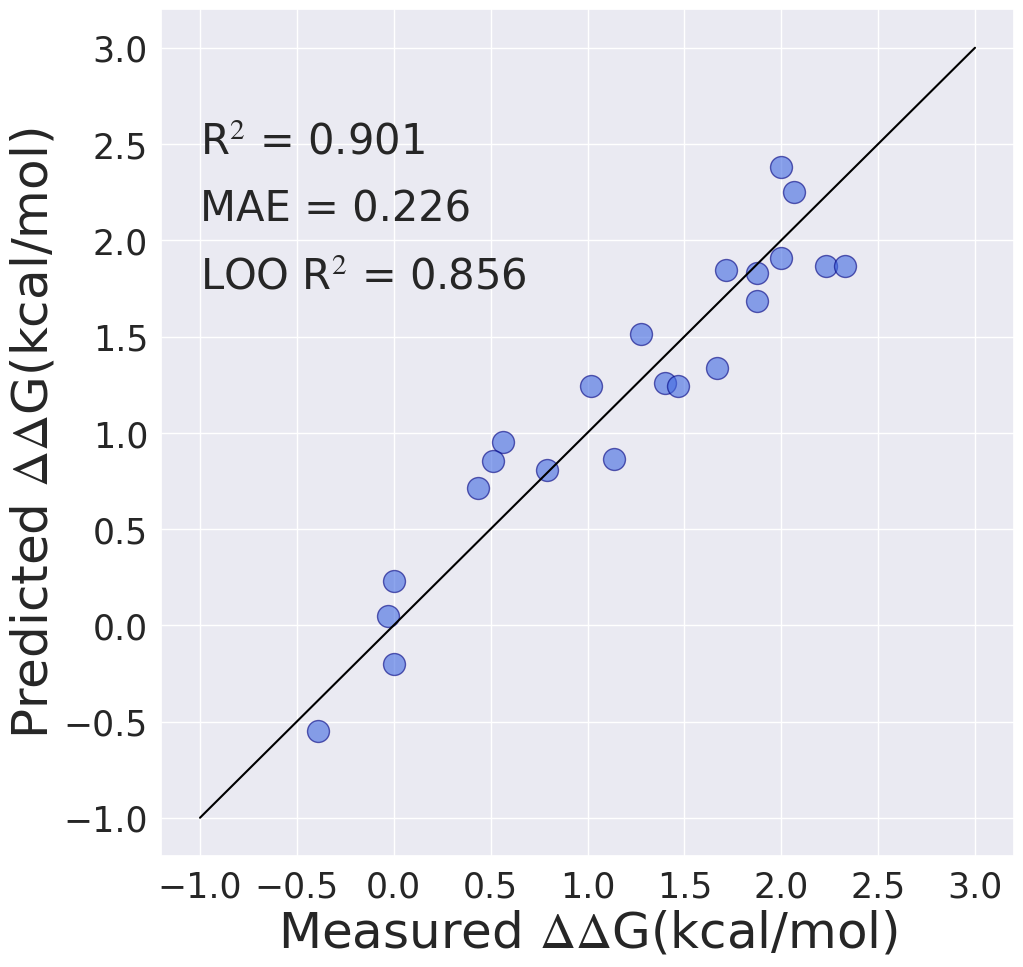

In [5]:
config = {
    "font.family": 'serif',
    "font.size": 8,
    "mathtext.fontset": 'stix',
    "font.serif": ['Arial'],
}
plt.rcParams.update(config)

test=scaler.inverse_transform(output['y_test'].values.reshape(-1,1))
pred=scaler.inverse_transform(output['predict_y'].reshape(-1,1))

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
        edgecolor='black')
plt.scatter(test,pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,3],[-1,3],c='black')
plt.xticks(np.arange(-1,3.1,0.5))
plt.yticks(np.arange(-1,3.1,0.5))
ax=plt.gca()

plt.xlabel(r"Measured $\Delta \Delta $G(kcal/mol)", fontsize=36)
plt.ylabel("Predicted $\Delta \Delta $G(kcal/mol)",fontsize=36)
plt.tick_params(labelsize=25)
plt.text(-1,1.75,'LOO R$^2$ = %.3f'%(output['LOO score']),fontsize=30)
plt.text(-1,2.1,'MAE = %.3f'%(mean_absolute_error(pred,test)),fontsize=30)
plt.text(-1,2.45,'R$^2$ = %.3f'%r2_score(test,pred),fontsize=30)
plt.show()

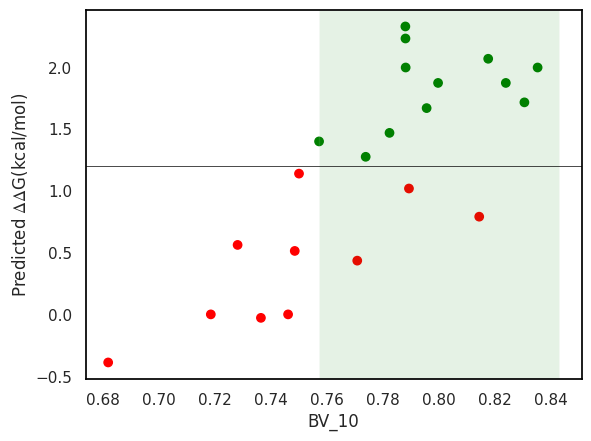

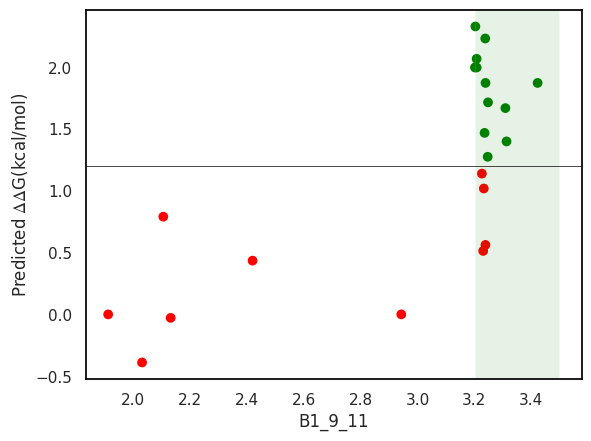

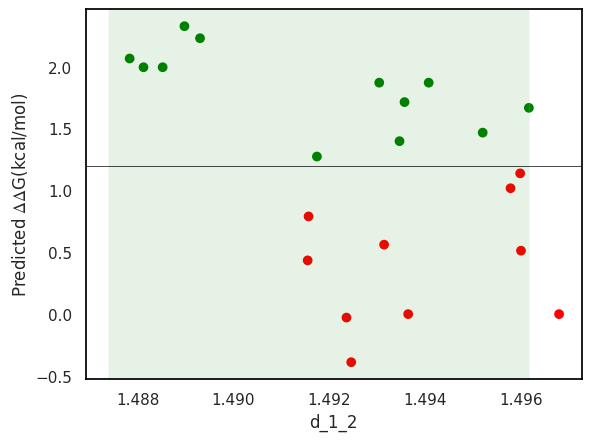

In [7]:
threshold = 1.2
for des in ['BV_10', 'B1_9_11', 'd_1_2']:
    
    colors = ['green' if value > threshold else 'red' for value in ddG]
    plt.scatter(combined_df[des], ddG, color=colors)
    plt.axhline(y=threshold, color='black', linestyle='-', linewidth=0.5)
    
    # 背景已经是白色，但如果您想明确设置：
    plt.gca().set_facecolor('white')

    # 设置边框颜色为黑色
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')

    # 使用条件表达式来确定绘制阴影区域的最小和最大x值
    sele = [value for m, value in enumerate(combined_df[des]) if ddG[m] > threshold]
    if min(sele) == min(combined_df[des]):
        xmin = plt.xlim()[0]
    else:
        xmin = min(sele)
    if max(sele) == max(combined_df[des]):
        xmax = plt.xlim()[1]
    else:
        xmax=max(sele)
    plt.axvspan(xmin=xmin, xmax=xmax, facecolor='green', alpha=0.1)
    
    # 设置轴标签
    plt.xlabel(des)
    plt.ylabel('Predicted $\Delta \Delta $G(kcal/mol)')
    
    # 显示图形
    plt.show()

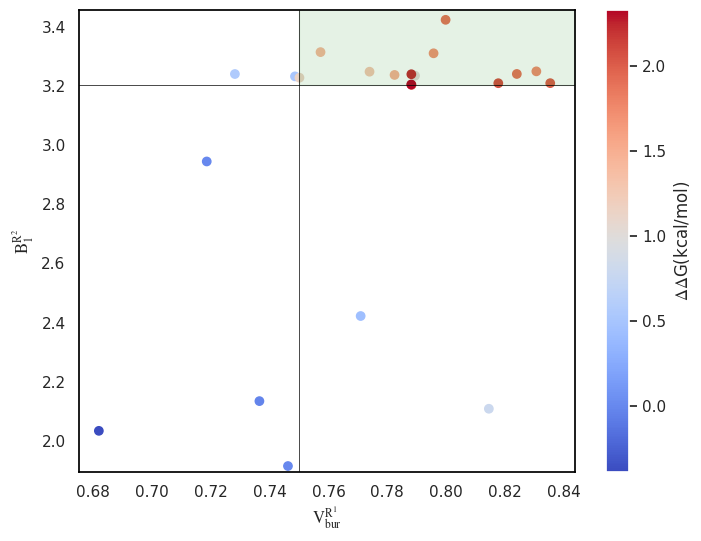

In [15]:
des1,des2='BV_10','B1_9_11'
plt.figure(figsize=(8,6))
plt.gca().set_facecolor('white')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
scatter=plt.scatter(combined_df[des1], combined_df[des2], c=ddG,cmap='coolwarm')
plt.colorbar(scatter).set_label('$\Delta \Delta $G(kcal/mol)')

plt.axhline(y=3.2, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=0.75, color='black', linestyle='-', linewidth=0.5)

x_max = max(combined_df[des1])
y_max = max(combined_df[des2])
plt.ylim([min(combined_df[des2])*0.99, y_max * 1.01])
plt.xlim([min(combined_df[des1])*0.99, x_max * 1.01])
plt.fill_between([0.75, x_max * 1.05], 3.2, y_max * 1.05, color='green', alpha=0.1)

plt.xlabel(r'$\mathrm{V_{bur}^{R^1}}$')
plt.ylabel(r'$\mathrm{B_1^{R^2}}$')
plt.show()